In [1]:
!pip install git+https://github.com/openai/CLIP.git onnxruntime onnx-simplifier
!pip install -r requirements.txt

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-jorw2719
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-jorw2719
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
Processing /opt/qti-aic/dev/lib/x86_64/qaic-0.0.1-py3-none-any.whl (from -r requirements.txt (line 7))
qaic is already installed with the same version as the provided wheel. Use --force-reinstall to force an installation of the wheel.


In [2]:
import argparse
import logging
import torch
from threading import Thread, Lock
from urllib.request import urlopen
import time
from transformers import CLIPProcessor, CLIPModel
from waggle.plugin import Plugin
from waggle.data.vision import Camera


import onnx
import onnxruntime
import subprocess
import os
import clip
from onnxsim import simplify
from typing import Tuple

/home/ubuntu/anaconda3/envs/clip/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
CLIP_BACKBONE = 'ViT-B/32'
CLIP_ONNX_EXPORT_PATH = 'clip.onnx'
CLIP_ONNX_EXPORT_PATH_SIMP = 'clip_simplified.onnx'

ONNX_INPUT_NAMES = ["IMAGE", "TEXT"]
ONNX_OUTPUT_NAMES = ["LOGITS_PER_IMAGE", "LOGITS_PER_TEXT"]
ONNX_DYNAMIC_AXES = {
    "IMAGE": {
        0: "image_batch_size",
    },
    "TEXT": {
        0: "text_batch_size",
    },
    "LOGITS_PER_IMAGE": {
        0: "image_batch_size",
        1: "text_batch_size",
    },
    "LOGITS_PER_TEXT": {
        0: "text_batch_size",
        1: "image_batch_size",
    },
}

In [4]:
def measure_mean_time_no_warmup(
    func, 
    func_inputs, 
    num_iters=250
) -> float:
    start_time = time.perf_counter()
    for _ in range(num_iters):
        func(*func_inputs)
    return (time.perf_counter() - start_time) / num_iters


def load_clip(backbone) -> Tuple[clip.model.CLIP, Tuple[torch.Tensor, torch.Tensor]]:
    pytorch_model, pre = clip.load(backbone)
    npx = pytorch_model.visual.input_resolution
    dummy_image = torch.randn(10, 3, npx, npx)
    dummy_texts = clip.tokenize(["quick brown fox", "lorem ipsum"])
    
    return pytorch_model, (dummy_image, dummy_texts)


def export_onnx(
    model, 
    inputs, 
    input_names,
    output_names,
    dynamic_axes,
    export_path
) -> None:
    torch.onnx.export(
        model=model, 
        args=inputs, 
        f=export_path, 
        export_params=True,
        input_names=input_names,
        output_names=output_names,
        opset_version=11,
        dynamic_axes=dynamic_axes
    )

In [5]:
pytorch_model, dummy_input = load_clip(backbone=CLIP_BACKBONE)
pytorch_model.eval()

export_onnx(
    model=pytorch_model,
    inputs=dummy_input,
    input_names=ONNX_INPUT_NAMES,
    output_names=ONNX_OUTPUT_NAMES,
    dynamic_axes=ONNX_DYNAMIC_AXES,
    export_path=CLIP_ONNX_EXPORT_PATH,
)

/home/ubuntu/anaconda3/envs/clip/lib/python3.8/site-packages/torch/onnx/symbolic_opset9.py:5408: UserWarning: Exporting aten::index operator of advanced indexing in opset 11 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, and Gather. If indices include negative values, the exported graph will produce incorrect results.
  warnings.warn(


In [7]:
ort_sess = onnxruntime.InferenceSession(CLIP_ONNX_EXPORT_PATH)

In [8]:
with torch.no_grad():
    pytorch_output = pytorch_model(*dummy_input)
onnx_output = ort_sess.run(ONNX_OUTPUT_NAMES, {"IMAGE": dummy_input[0].numpy(), "TEXT": dummy_input[1].numpy()})

assert all([torch.allclose(pt_pred, torch.tensor(onnx_pred)) for pt_pred, onnx_pred in zip(pytorch_output, onnx_output)])

print(f'Pytorch output: {pytorch_output}\n\nONNX output: {onnx_output}')

Pytorch output: (tensor([[19.8400, 24.8375],
        [19.8265, 24.7673],
        [19.3765, 24.6924],
        [20.1858, 24.6302],
        [20.3053, 24.8375],
        [19.9372, 24.7740],
        [19.7499, 24.7919],
        [19.4751, 24.8173],
        [19.5098, 24.7624],
        [19.9707, 25.0467]]), tensor([[19.8400, 19.8265, 19.3765, 20.1858, 20.3053, 19.9372, 19.7499, 19.4751,
         19.5098, 19.9707],
        [24.8375, 24.7673, 24.6924, 24.6302, 24.8375, 24.7740, 24.7919, 24.8173,
         24.7624, 25.0467]]))

ONNX output: [array([[19.839977, 24.83752 ],
       [19.826511, 24.767275],
       [19.376541, 24.69241 ],
       [20.18574 , 24.630148],
       [20.30528 , 24.837439],
       [19.937174, 24.773935],
       [19.749897, 24.79189 ],
       [19.475136, 24.817299],
       [19.509789, 24.762379],
       [19.970741, 25.046747]], dtype=float32), array([[19.839977, 19.826511, 19.376541, 20.18574 , 20.30528 , 19.937174,
        19.749897, 19.475136, 19.509789, 19.970741],
       [24.8

In [9]:
TOKENIZERS_PARALLELISM=True
!rm  -r '/home/ubuntu/clip_test/clip_qpc'

In [10]:
#run onnx runtime with qaic
import qaic
import sys
sys.path.append("/opt/qti-aic/examples/apps/qaic-python-sdk")

from common_utils import generate_bin
qpcPath = generate_bin(onnx_filename = '/home/ubuntu/clip_test/clip.onnx',yaml_filename ='/home/ubuntu/clip_test/clip_config.yaml')


INFO: Running the compile cmd: /opt/qti-aic/exec/qaic-exec -m=/home/ubuntu/clip_test/clip.onnx -aic-hw -aic-hw-version=2.0 -aic-num-cores=4 -convert-to-fp16 -mos=1 -ols=2 -multicast-weights -onnx-define-symbol=image_batch_size,1 -onnx-define-symbol=text_batch_size,3 -auto-batch-input -compile-only -aic-binary-dir=/home/ubuntu/clip_test/clip_qpc
Reading ONNX Model from /home/ubuntu/clip_test/clip.onnx
Compile started ............... 
Compiling model with FP16 precision.
Generated binary is present at /home/ubuntu/clip_test/clip_qpc


In [11]:
import sys
sys.path.append("/opt/qti-aic/examples/apps/qaic-python-sdk")
import qaic
import os
#sys.path.insert(1, os.path.join(os.path.dirname(os.path.realpath(__file__)), os.pardir))

In [ ]:
!/opt/qti-aic/tools/qaic-util -q

In [12]:
vit_sess = qaic.Session(model_path= qpcPath+'/programqpc.bin', options_path='/home/ubuntu/clip_test/clip_config.yaml')
vit_sess.setup() 

In [44]:
vit_sess.__dict__


{'_backend_obj': <qaic.backends.qaic_backend.QAicBackend at 0x7f294a4df670>,
 '_backend': 'qaic',
 '_metrics': <qaic.metrics.Metrics at 0x7f294a4dfd90>,
 '_compile': True,
 '_model_input_shape_dict': {'IMAGE': ((1, 3, 224, 224), 'float32'),
  'TEXT': ((3, 77), 'int32')},
 '_model_output_shape_dict': {'LOGITS_PER_IMAGE': ((1, 3), 'float32'),
  'LOGITS_PER_TEXT': ((3, 1), 'float32')},
 '_backend_options': {'dev_id': None, 'set_size': 4, 'num_activations': 2}}

In [13]:
image_input_shape, image_input_type = vit_sess.model_input_shape_dict['IMAGE']
text_input_shape,text_input_type=vit_sess.model_input_shape_dict['TEXT']
LPI_shape, LPI_type = vit_sess.model_output_shape_dict['LOGITS_PER_IMAGE']
LPT_shape, LPT_type= vit_sess.model_output_shape_dict['LOGITS_PER_TEXT']

In [15]:
from PIL import Image

In [19]:
processor=CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
sample_text=["this is a dog walking","this is a fish","a man is sleeping"]
sample_image="test_images/ILSVRC2012_test_00000003.JPEG"
input_text=clip.tokenize(sample_text)
inputs = processor(text=sample_text, images=Image.open(sample_image), return_tensors="pt", padding=True)

In [46]:
show_image=Image.open(sample_image)

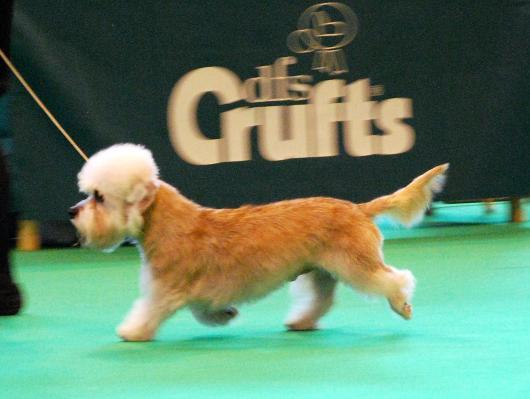

In [47]:
show_image

In [24]:
import numpy

In [26]:
device=True
if device:
    print("INFO: running inference on Qualcomm Cloud AI 100")
    image_data = inputs['pixel_values'].numpy().astype(image_input_type)
    text_data= inputs['input_ids'].numpy().astype(text_input_type)
    input_dict = {'IMAGE': image_data,'TEXT': input_text.numpy().astype(text_input_type)}
    output = vit_sess.run(input_dict) #**input
    logits_per_image = numpy.frombuffer(output['LOGITS_PER_IMAGE'], dtype=LPI_type).reshape(LPI_shape)# dtype to be modified based on given model
    logits_per_text = numpy.frombuffer(output['LOGITS_PER_TEXT'], dtype=LPT_type).reshape(LPT_shape)
else:
    print("INFO: running inference on CPU")
    outputs = model(**inputs)
    logits = outputs.logits
print(logits_per_image,logits_per_text)


INFO: running inference on Qualcomm Cloud AI 100
[[22.859375 17.734375 13.875   ]] [[22.859375]
 [17.734375]
 [13.875   ]]


In [42]:
probs = torch.tensor(logits_per_image).softmax(dim=1)
results=[]
for prob, logits, description in sorted(zip(probs.view(-1), torch.tensor(logits_per_image).view(-1), sample_text)):
                # TODO prefer similarity score to softmax prob for thresholding. software prob can give unituitive
                # results - for example, when a single text is provided, that will always be published.
                results.append(f"{logits:0.3f} {prob:0.3f} {marker} {description}")
print(results)

['13.875 0.000 * a man is sleeping', '17.734 0.006 * this is a fish', '22.859 0.994 * this is a dog walking']
